In [1]:
import msprime, tskit
from IPython.display import SVG
import numpy as np
import matplotlib.pyplot as plt
from algorithm import *

In [2]:
ts2 = msprime.sim_ancestry(3, population_size=100, sequence_length=1e5, recombination_rate=1e-8,
                         record_full_arg=True)

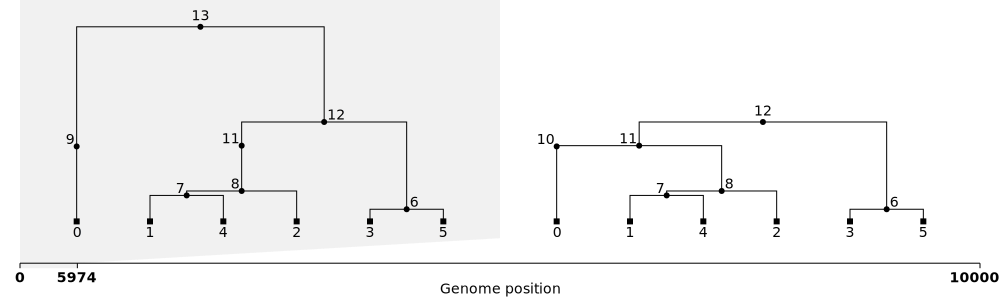

In [5]:
SVG(ts2.draw_svg(size=(1000, 300), x_lim=[0, 1e5]))

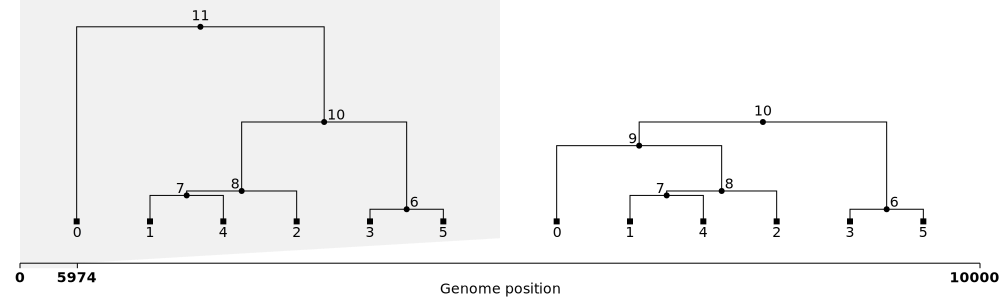

In [6]:
sts = ts2.simplify()
SVG(sts.draw_svg(size=(1000, 300), x_lim=[0, 1e5]))

[13, 12]


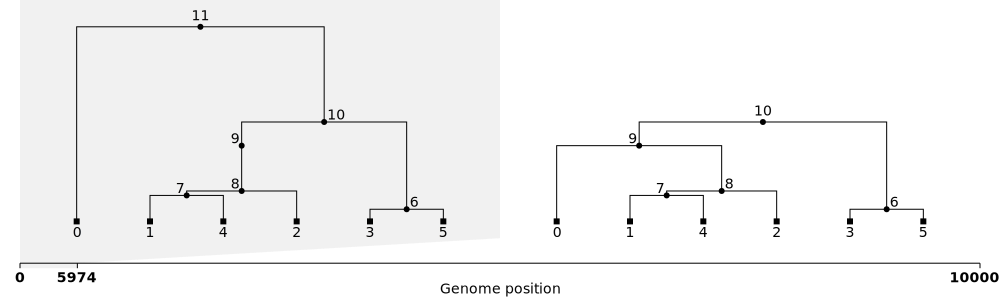

In [7]:
ts1, n = extend_edges(sts)
print(n)
SVG(ts1.draw_svg(size=(1000, 300), x_lim=[0, 1e5]))

Our goal is to construct a function to measure the number of discrepancies between our inferred tree sequence $TS_1$ and the ground truth $TS_2$. For tree sequences $TS_1$ and $TS_2$ both of sequence length $L$, each have nodes at position $i$ in the genome, $x$ and $y$ respectively. From these nodes we count the number of samples which stem from them. We define these sets as $D_1(i,x)$ and $D_2(i,y)$. We count the number of descrepancies between the nodes $x$ and $y$ as their set difference, $|D_1(i,x)\vartriangle D_2(i,y)|$. We define the $\textbf{discrepancy number}$ between nodes $x$ and $y$ as 
$$ d(x,y) = \sum_{i=0}^{L-1} |D_1(i,x)\vartriangle D_2(i,y)|. $$
Using this we generalize to find the number of discrepancies between a node $x$ and the ground truth $TS_2$,
$$ d(x,TS_2) = \inf_{y\in TS_2.nodes()} d(x,y).$$
Finally, to compute the number of discrepancies between tree sequences we use the function
$$d(TS_1,TS_2) = \sum_{x\in TS_1.nodes()} d(x,TS_2)=\sum_{x\in TS_1.nodes()} \inf_{y\in TS_2.nodes()} d(x,y) = \sum_{x\in TS_1.nodes()} \inf_{y\in TS_2.nodes()} \sum_{i=0}^{L-1} |D_1(i,x)\vartriangle D_2(i,y)|,$$
and call this the $\textbf{discrepancy number}$ between $TS_1$ and $TS_2$.

In [26]:
def node_discrepancy(x, ts1, y, ts2):
    # function to return the discrepancy number between two nodes, d(x,y)
    dis = 0
    for interval, t1, t2 in ts1.coiterate(ts2):
        s = interval.span
        Dx = set(t1.samples(x))
        for z in t2.samples(y):
            if z not in Dx:
                dis += s
    return dis

def node_tree_discrepancy(x, ts1, ts2): # I tried to make the function faster, I am not sure if it does though
    # function to return the discrepancy number between a node and tree sequence d(x,TS2)
    dis = ts2.sequence_length
    for y in range(ts2.num_nodes):
        xydis = node_discrepancy(x, ts1, y, ts2)
        if xydis < dis:
            dis = xydis
    
    return dis # Perhaps we could also have this function also return a list of the nodes which give us the minimal discrepancy number

def node_tree_discrepancy2(x, ts1, ts2):
    dis = np.zeros(ts2.num_nodes)
    for interval, t1, t2 in ts1.coiterate(ts2):
        s = interval.span
        Dx = set(t1.samples(x))
        for y in t2.nodes():
            n = len(set(t2.samples(y)) - Dx)
            dis[y] += n * s
    return np.min(dis)

In [28]:
tsA = msprime.sim_ancestry(num_samples, population_size=1000, sequence_length=1e5,
                           recombination_rate=1e-8, record_full_arg=True)
tsB = msprime.sim_ancestry(num_samples, population_size=1000, sequence_length=1e5,
                           recombination_rate=1e-8, record_full_arg=True)
for j in range(10):
    assert np.all(node_tree_discrepancy(j, tsA, tsA) == 0)
    assert np.all(node_tree_discrepancy2(j, tsA, tsA) == 0)
    assert np.allclose(
        node_tree_discrepancy(j, tsA, tsB),
        node_tree_discrepancy2(j, tsA, tsB)
    )

In [29]:
def discrepancy(ts1, ts2):
    dis = 0
    
    for n in range(ts1.num_nodes):
        dis += node_tree_discrepancy2(n,ts1,ts2)
    return dis

In [10]:
discrepancy(ts1, ts2)

0

Now we should run an experiment to see with our new metric the varying distribution of the disscrepancy number between the simulated tree sequence and its edge extended version.

In [11]:
for num_samples in [3, 5,7,9]:
    for L in [1e4, 1e5, 1e6,1e7]:
        ts = msprime.sim_ancestry(num_samples, population_size=1000, sequence_length=L,
                                  recombination_rate=1e-8, record_full_arg=True)
        sts = ts.simplify()
        
        ext_sts, _ = extend_edges(sts)
        #dd = orig_discrepancy(ext_sts, ts)
        d = discrepancy(ext_sts, ts)
        print(f'number of samples = {num_samples}, length = {L}\n original discrepancy number = {d}')

number of samples = 3, length = 10000.0
 original discrepancy number = 0
number of samples = 3, length = 100000.0
 original discrepancy number = 7494.0
number of samples = 3, length = 1000000.0
 original discrepancy number = 1736.0


KeyboardInterrupt: 

# TODO: explain what happens here

In [14]:
def node_tree_discrepancy3(x, ts1, ts2):
    dis = np.zeros(ts2.num_nodes)
    for interval, t1, t2 in ts1.coiterate(ts2):
        s = interval.span
        # note that Dx might not have changed since the last tree
        Dx = set(t1.samples(x))
        if len(Dx) > 1:
            y = t2.mrca(*list(Dx))
            dis[y] += (set(t2.samples(y)) == Dx) * s
    return np.min(ts1.sequence_length - dis)

In [12]:
def discrepancy3(ts1, ts2):
    dis = 0
    
    for n in range(ts1.num_nodes):
        dis += node_tree_discrepancy3(n,ts1,ts2)
    return dis

TODO:

1. write down the math for this new definition
2. IS THIS RIGHT, EVEN?
3. check whether dis(ts1, ts2) = dis(ts2, ts1) = 0 then ts1 == ts2?
4. make a plot of runtime of dis( ) as a function of number of nodes? of trees?


In [15]:
for num_samples in [3, 5,7,9]:
    for L in [1e4, 1e5, 1e6,1e7]:
        ts = msprime.sim_ancestry(num_samples, population_size=1000, sequence_length=L,
                                  recombination_rate=1e-8, record_full_arg=True)
        sts = ts.simplify()
        
        ext_sts, _ = extend_edges(sts)
        d = discrepancy3(ext_sts, ts)
        print(f'number of samples = {num_samples}, length = {L}\n original discrepancy number = {d}')

number of samples = 3, length = 10000.0
 original discrepancy number = 60000.0
number of samples = 3, length = 100000.0
 original discrepancy number = 1200000.0
number of samples = 3, length = 1000000.0
 original discrepancy number = 55803334.0
number of samples = 3, length = 10000000.0
 original discrepancy number = 5538431829.0
number of samples = 5, length = 10000.0
 original discrepancy number = 100000.0
number of samples = 5, length = 100000.0
 original discrepancy number = 1470286.0
number of samples = 5, length = 1000000.0
 original discrepancy number = 69466078.0
number of samples = 5, length = 10000000.0
 original discrepancy number = 6053643653.0
number of samples = 7, length = 10000.0
 original discrepancy number = 140000.0
number of samples = 7, length = 100000.0
 original discrepancy number = 2163788.0
number of samples = 7, length = 1000000.0
 original discrepancy number = 68598523.0
number of samples = 7, length = 10000000.0
 original discrepancy number = 7389889677.0
nu